# Analyzing SASUMO outputs

### Import the Required Libraries

In [1]:
# %%capture
# !pip install SALib
# !pip install pint-pandas
# !pip install pint
# !pip install plotly
# !pip install lxml

In [2]:
import os
import sys

In [3]:
def find_root(path):
    if os.path.split(path)[-1] != 'airport-harper-sumo':
        return find_root(os.path.split(path)[0])
    return path

In [4]:
PATH = !pwd  # a bit of Jupyter Magic to get the working path
PATH = find_root(PATH[0])
if PATH not in sys.path:
    print(f"adding {PATH} to path")
    sys.path.append(PATH)

# Add savvy to the path
sys.path.append(os.path.join(os.getcwd(), 'savvy',))

adding /home/max/remote/airport-harper-sumo to path


In [63]:
import json5 as json
import sys
import pickle
import csv
import copy

import numpy as np
import pandas as pd 
import pint
import pint_pandas
import plotly.graph_objects as go

from SALib.analyze import sobol
from SASUMO.SASUMO.params import Settings4SASUMO

In [6]:
ureg = pint.UnitRegistry()

## Defining the Analysis Root

In [7]:
ROOT = r"/media/HDD/max/sasumo-files/630AM_6_Parameter_Narrow_Dist/2021_09_19-05_09_10"
TOP_LEVEL_SETTINGS = os.path.join(ROOT, "settings.yaml")
OUTPUT= os.path.join(ROOT, "output.txt")
PROBLEM = os.path.join(ROOT, "SALib_Problem.json")

In [8]:
# with open(TOP_LEVEL_SETTINGS, 'rb') as f:
settings = Settings4SASUMO(TOP_LEVEL_SETTINGS)

## Open up the Problem

In [9]:
with open(PROBLEM, 'r') as f:
    problem = json.load(f)
problem

{'num_vars': 6,
 'names': ['FleetComposition_fleet_composition',
  'CarFollowingParameters_delta',
  'PersonalCar_tau',
  'PersonalCar_accel',
  'Class8Truck_tau',
  'Class8Truck_accel'],
 'bounds': [[0.0, 0.4], [1, 10], [0.5, 3], [3, 6], [0.5, 3], [1, 3]]}

## Creating a table of the Results and Parameters

In [10]:
results = []
param_keys = []
for _dir in os.scandir(ROOT):
    if _dir.is_dir():
        # reading the fuel consumption in 
        try:
            with open(os.path.join(_dir.path, 'f_out.txt'), 'r') as f:
                fc = float(f.read())
        except:
            print(f"issue with {_dir.path}")
        with open(os.path.join(_dir.path, 'sa_values.json'), 'r') as f:
            _d = json.loads(f.read())
            if not param_keys:
                param_keys = list(_d.keys())
            params = [_d[_k] for _k in param_keys]
        results.append([int(_dir.name.split("_")[1]), fc, *params])

In [11]:
results_df = pd.DataFrame.from_records(results, columns=['Sample_Num', 'f_out', *param_keys],)

# results_df.
results_df.set_index('Sample_Num', inplace=True)
results_df.sort_index(inplace=True)
results_np = results_df['f_out'].values
# results_df.head()

In [12]:
results_df['Fuel [gal]'] = results_df['f_out'] * (1* ureg.milliliter).to('gallon').magnitude
results_df.head()

,f_out,FleetComposition_fleet_composition,CarFollowingParameters_delta,PersonalCar_tau,PersonalCar_accel,Class8Truck_tau,Class8Truck_accel,Fuel [gal]
Sample_Num,,,,,,,,
0,186872.442999,0.0,1.0,0.5,3.0,0.5,1.0,49.366477
1,184880.135999,0.0,1.0,0.5,3.0,0.5,1.0,48.840165
2,187734.095999,0.0,1.0,0.5,3.0,0.5,1.0,49.594101
3,185790.090999,0.0,1.0,0.5,3.0,0.5,1.0,49.080550
4,187089.007999,0.0,1.0,0.5,3.0,0.5,1.0,49.423687


## Perform the Sobol Analysis

In [13]:
Si = sobol.analyze(problem, results_np, print_to_console=False, calc_second_order=True)

## Plotting using Savvy 

In [14]:
import savvy.interactive_plots as ip
import savvy.network_tools as nt
import savvy.data_processing as dp

from bokeh.plotting import show, output_notebook
output_notebook()

/home/max/.local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



Loading BokehJS ...

In [15]:
savvy_d = dp.format_salib_output(Si, run_name='630AM_6_Parameter_Narrow_Dist', pretty_names={'FleetComposition_fleet_composition': "Fleet Composition", "CarFollowingParameters_delta" : "Delta", "PersonalCar_tau": "Tau_PC"})

In [16]:
# df_list = Si.to_df()
# pretty_names={'FleetComposition_fleet_composition': "Fleet Composition", "CarFollowingParameters_delta" : "Delta", "PersonalCar_tau": "Tau_PC"}

# # combine S1 and ST
# df_list[0] = pd.concat((df_list[0], df_list[1]), axis=1)
# df_list.pop(1)
# df_list[0]['Parameter'] = df_list[0].index

# df_list[0]["Parameter"] = df_list[0]['Parameter'].map(pretty_names).fillna(df_list[0]['Parameter'])
# df_list[0]

In [17]:
# sa_dict = dp.get_sa_data()
ip.interact_with_plot_all_outputs(savvy_d)

interactive(children=(BoundedFloatText(value=0.01, description='Min value:', max=1.0), IntText(value=20, descr…

<function savvy.interactive_plots.plot_all_outputs(sa_dict, demo=False, min_val=0.01, top=100, stacked=True, error_bars=True, log_axis=True, highlighted_parameters=[])>

In [18]:
ip.plot_all_second_order(savvy_d, top=6, mirror=True)

Created a graph with 6 vertices and 15 edges.
Vertices are the top 10 ST values greater than 1e-06.
Only S2 values (edges) greater than -2 are included.


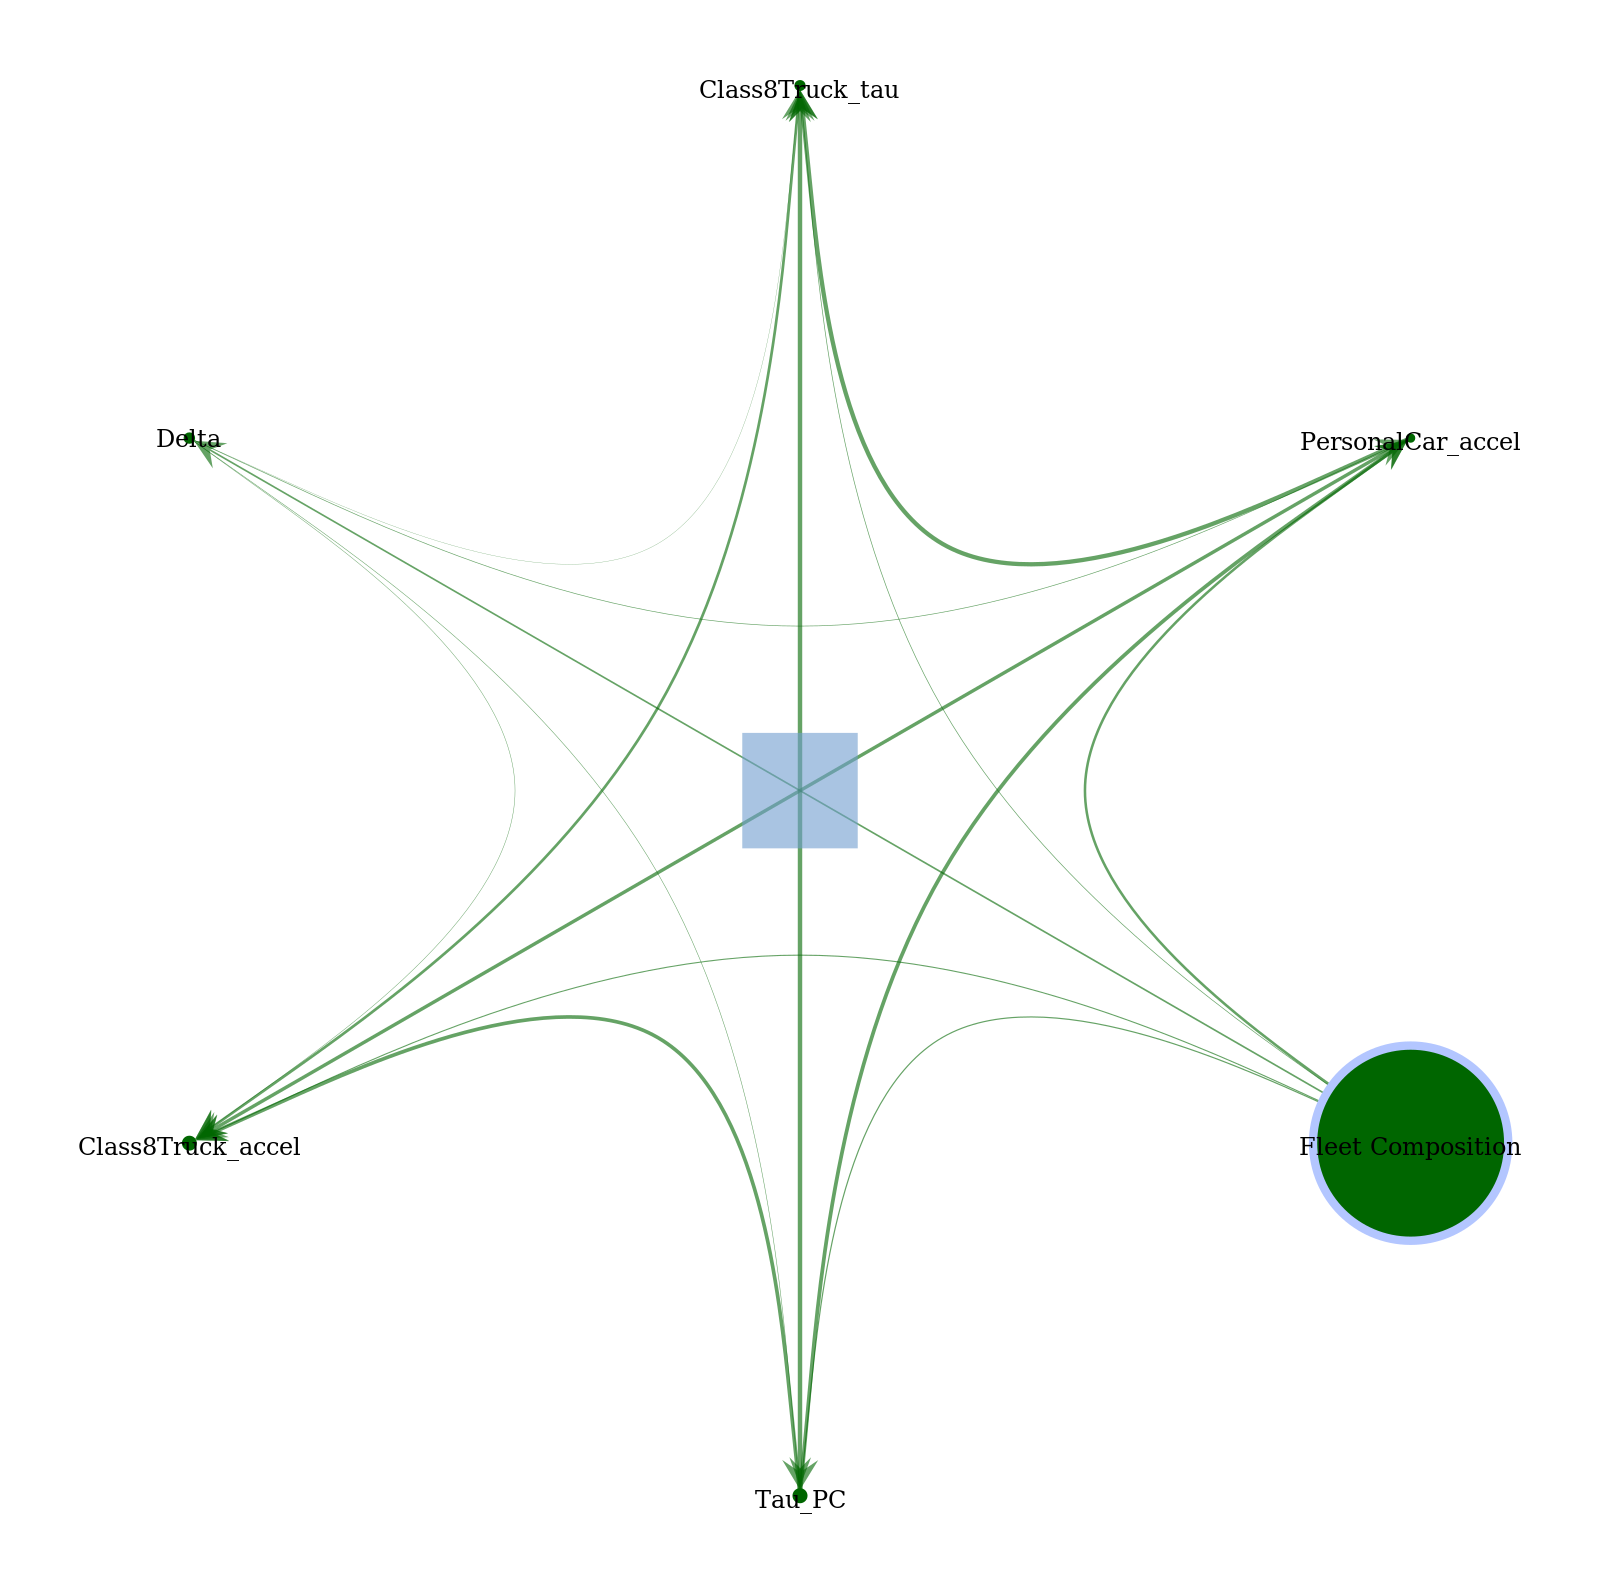

In [19]:
sa_dict_net = copy.deepcopy(savvy_d)
g = nt.build_graph(savvy_d['630AM_6_Parameter_Narrow_Dist'], sens='ST', top=10, min_sens=1e-6, edge_cutoff=-2, edge_width=100,) #log=True)
nt.plot_network_circle(g, inline=True, scale=100, output_size=(800, 800))
# test = nt.plot_network_random(g, scale=200)

## Plotting the Results

### Surface Plot

In [72]:
from scipy import interpolate

In [137]:
x_name = "PersonalCar_tau"
y_name = "PersonalCar_accel"

In [136]:
series = results_df.groupby(['PersonalCar_tau', 'PersonalCar_accel'])["Fuel [gal]"].median()
series = series.reset_index()
# series.sort_values('FleetComposition_fleet_composition', ascending=False).head(30)

In [105]:
x = series['FleetComposition_fleet_composition'].values
y = series['Class8Truck_accel'].values
z = series['Fuel [gal]'].values
# X, Y = np.meshgrid(x, y)

In [116]:
f = interpolate.interp2d(x, y, z, kind="cubic")

In [117]:
xx = np.linspace(min(x), max(x), 100)
yy = np.linspace(min(y), max(y), 100)
znew = f(xx, yy)

In [115]:
series['Fuel [gal]'].max()

255.72916005320255

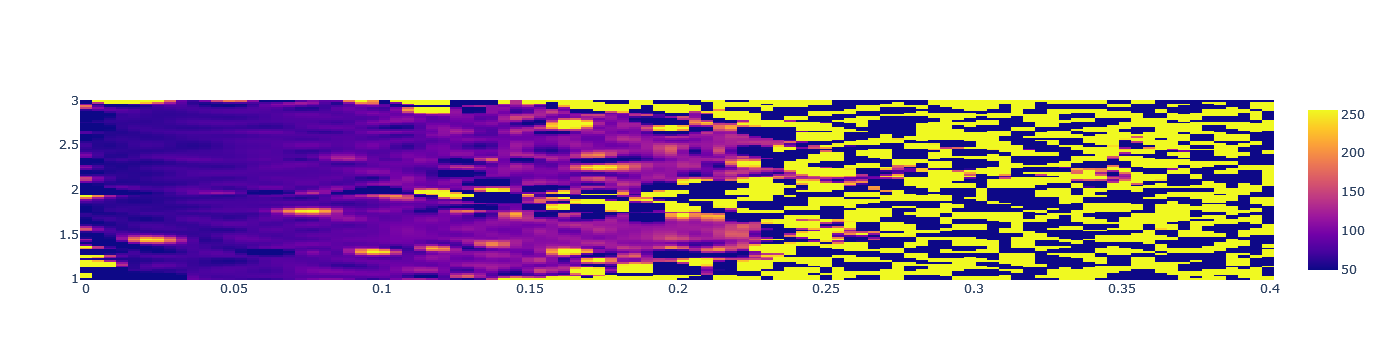

In [127]:
fig = go.Figure(data=go.Heatmap(
                    x=xx,
                    y=yy,
                    z=znew,
                    zmin=min(z), 
                    zmax=max(z)
                )
               )

fig.update_layout()
fig.show()

In [124]:
dict(cmin=min(z), cmax=max(z))

{'cmin': 49.29136237906198, 'cmax': 255.72916005320255}

### FC vs Sim #

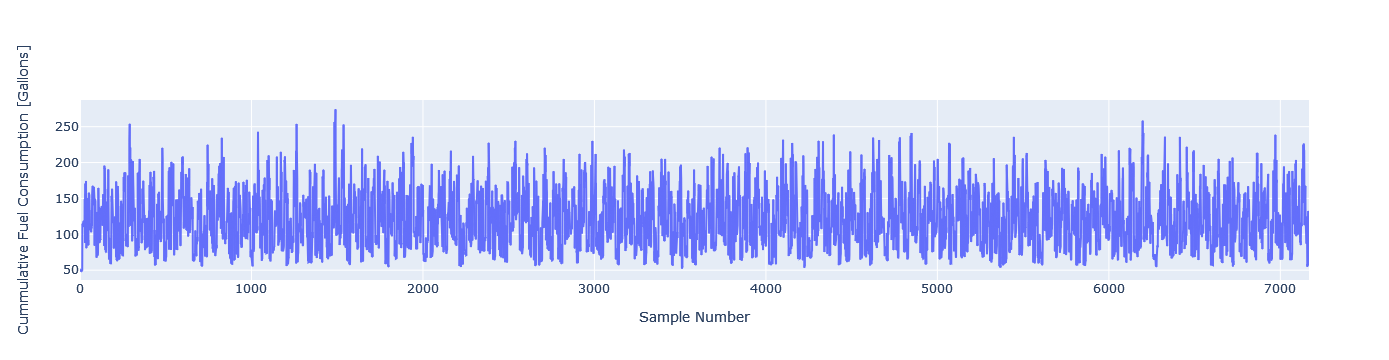

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Fuel [gal]'], mode='lines'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Sample Number')
                 )
fig.show()

In [26]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['FleetComposition_fleet_composition'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Fleet Composition [% Truck]')
#                  )
# fig.show()

In [27]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['PersonalCar_tau'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Tau [s]')
#                  )
# fig.show()

In [28]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['CarFollowingParameters_delta'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Delta')
#                  )
# fig.show()

In [29]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['PersonalCar_accel'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Accel [m/s^2]')
#                  )
# fig.show()

In [30]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_tau'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Tau [s]')
#                  )
# fig.show()

In [31]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_delta'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Delta')
#                  )
# fig.show()

In [33]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_accel'], y=results_df['Fuel [gal]'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Accel [m/s^2]')
#                  )
# fig.show()